In [3]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

import operator
import matplotlib.pyplot as plt


def plot_cut_2mers(datafr, cut_mat) :
    cut_mer2 = {}

    seqs = list(datafr['seq'].values)
    seqs = np.array(seqs, dtype=np.object)

    total_count = np.array(datafr['total_count'])

    cx = sp.coo_matrix(cut_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = seqs[i]

        mer2 = seq[j-1:j+1]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += v

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc.', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [4]:
library_name = 'doubledope_score_50'
library_version = 'unfiltered'

In [3]:
raw_data_name = 'with_barcode/doubledope_library_hamming2_dna_antimisprime_rna_antimisprime_score_50'
data = pd.read_csv(raw_data_name + '.csv', sep=',').reset_index(drop=True)

In [5]:
emitted_proximal_count = []
emitted_distal_count = []
emitted_total_count = []
emitted_seq = []
emitted_mask = []
emitted_lib = []
emitted_lib_index = []
emitted_sublib = []
emitted_sublib_index = []

proximal_cuts = sp.lil_matrix((len(data), 206)) #PAS CSE starts at 70


In [5]:
up_constant = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTACACGACGCTCTTCCGATCT'
dn_constant = 'CTACGAACTCCCAGCGCAGAACACAGCGGTTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTGCCCCTCCCCCGTGCCTTCCTTGACCCTGGAAGGTGCCACTCCCACTGTCCTTTCCTAATAAAATGAGGAAATTGCATCGCATTGTCTGAGTAGGTGTCATTCTATTCTGGGGGGTGGGGTGGGGCAGGACAGCAAGGGGGAGGATTGGGAAGACAATAGCAGGCATGCXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [6]:

#Store library meta data

library_list = []
library_index_list = []
sublibrary_list = []
sublibrary_index_list = []
upstream_padding_list = []
downstream_padding_list = []

for pas_shift in range(-4, 4 + 1) :
    library_list.append('doubledope')
    library_index_list.append(20)
    sublibrary_list.append('doubledope_5prime_' + str(pas_shift))
    sublibrary_index_list.append(205 + pas_shift)
    
    upstream_padding_list.append(up_constant[-10 + pas_shift - 190:-10 + pas_shift])
    downstream_padding_list.append(dn_constant[5 + pas_shift:5 + pas_shift + 120])
    

df_metadata = pd.DataFrame(
    {
        'library' : library_list,
        'library_index' : library_index_list,
        'sublibrary' : sublibrary_list,
        'sublibrary_index' : sublibrary_index_list,
        'upstream_padding' : upstream_padding_list,
        'downstream_padding' : downstream_padding_list
    }
)

df_metadata = df_metadata[['library', 'library_index', 'sublibrary', 'sublibrary_index', 'upstream_padding', 'downstream_padding']]

df_metadata.to_csv(library_name + '_metadata.csv', header=True, index=False, sep=',')



In [7]:
#Make Valid PAS lookup hierarchy

cano_pas1 = 'AATAAA'
cano_pas2 = 'ATTAAA'

valid_pas = []

valid_pas.append({})
valid_pas[0]['AATAAA'] = True

valid_pas.append({})
valid_pas[1]['ATTAAA'] = True

valid_pas.append({})
valid_pas[2]['AGTAAA'] = True
valid_pas[2]['TATAAA'] = True
valid_pas[2]['CATAAA'] = True
valid_pas[2]['GATAAA'] = True

valid_pas.append({})
for pos in range(0, 6) :
    for base in ['C', 'G', 'T'] :
        valid_pas[3][cano_pas1[:pos] + base + cano_pas1[pos+1:]] = True

valid_pas.append({})
valid_pas[4]['AGGAAA'] = True
valid_pas[4]['ACCAAA'] = True
valid_pas[4]['AACAAA'] = True
valid_pas[4]['AAGAAA'] = True
valid_pas[4]['TACAAA'] = True
valid_pas[4]['TAGAAA'] = True
valid_pas[4]['ATTATA'] = True
valid_pas[4]['ATTACA'] = True
valid_pas[4]['ATTAGA'] = True

In [8]:
move_cut_to_non_a = True
align_on_pas = True
pas_align_window = 4

for index, row in data.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))

    seq = row['sequence']
    mask = ('N' * 20) + ('X' * 15) + ('N' * (25 + 6 + 40)) + ('X' * 14) + ('N' * (25 + 6 + 40))

    cut_str = row['proximal_cuts']
    cut_str = cut_str[1:len(cut_str)-1]
    cuts_member = cut_str.split(', ')
    
    proximal_count = row['proximal_count']
    distal_count = row['distal_count']
    total_count = row['total_count']
    
    pas_shift = 0
    if align_on_pas :
        found_pas = False
        pas_start = 60
        for j in range(0, pas_align_window + 1) :
            for j_dir in [-1, 1] :
                i_start = pas_start - j * j_dir
                i_end = pas_start - j * j_dir + 6
                for k in range(0, len(valid_pas)) :
                    if seq[i_start:i_end] in valid_pas[k] and valid_pas[k][seq[i_start:i_end]] == True :
                        pas_shift = i_start - pas_start
                        found_pas = True
                        break

                if found_pas :
                    break
            
            if found_pas :
                break
    
    full_seq = (up_constant[-10 + pas_shift:] + seq + dn_constant)[:206]
    full_mask = ('X' * (10 - pas_shift)) + mask + ('X' * 300)[:206]

    total_count_check = distal_count
    if cut_str != '' :
        for j in range(0, len(cuts_member)) :
            cutpos = int(cuts_member[j]) + 10 - pas_shift
            total_count_check += 1

            if move_cut_to_non_a :
                jj_char = 0
                while full_seq[cutpos-1] == 'A' and jj_char < 2 and cutpos > 0 :
                    cutpos -= 1
                    jj_char += 1

            proximal_cuts[index, cutpos] += 1

    if total_count_check != total_count :
        print('ERROR! Total count mismatch.')
    
    #Emit 5' Proximal PAS variant

    #Sequence length 206
    emitted_seq.append(full_seq)
    emitted_mask.append(full_mask)
    
    emitted_lib.append('doubledope')
    emitted_lib_index.append(20)
    emitted_sublib.append('doubledope_5prime_' + str(pas_shift))
    emitted_sublib_index.append(205 + pas_shift)

    emitted_proximal_count.append(proximal_count)
    emitted_distal_count.append(distal_count)
    emitted_total_count.append(total_count)

Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000
Read up to sequence: 900000
Read up to sequence: 1000000
Read up to sequence: 1100000
Read up to sequence: 1200000
Read up to sequence: 1300000


In [9]:

#Inflate dataframe

df = pd.DataFrame({'seq'  : emitted_seq,
                    'mask'  : emitted_mask,
                    'proximal_count'  : emitted_proximal_count,
                    'distal_count'  : emitted_distal_count,
                    'total_count'  : emitted_total_count,
                    'library'  : emitted_lib,
                    'library_index'  : emitted_lib_index,
                    'sublibrary'  : emitted_sublib,
                    'sublibrary_index'  : emitted_sublib_index
                })


In [10]:

#Simultaneously sort dataframe and cut matrices

total_count = np.array(df['total_count'])
sort_index = np.argsort(total_count)

df = df.iloc[sort_index].reset_index(drop=True)
proximal_cuts = proximal_cuts[sort_index]


In [11]:

#Store dataframe and cut matrices

df = df[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts})


In [12]:

#Read dataframe and cut matrices

df = pd.read_csv(library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts = spio.loadmat(library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df))


1310490


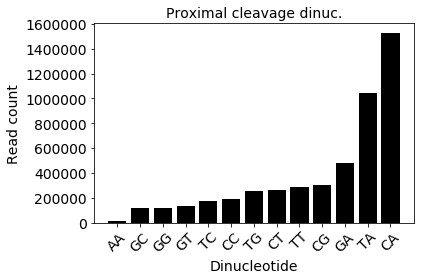

In [13]:
plot_cut_2mers(df, proximal_cuts)

In [14]:
import regex as re

#Filter dataframe and cut matrices

misprime_regexes = [
    re.compile(r"(AAAAAAAAAAA){s<=2}"),
    re.compile(r"(AAAAAAAAAAAAAAAA){s<=4}"),
    re.compile(r"(AAAAAAAAAAAAAAAAAAAA){s<=5}")
]

keep_index = []
for index, row in df.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))
    
    curr_seq = row['seq']
    
    internal_priming = False
    for misprime_regex in misprime_regexes :
        if re.search(misprime_regex, curr_seq) :
            internal_priming = True
            break
    
    if not internal_priming :
        keep_index.append(index)


df_cleaned = df.iloc[keep_index].reset_index(drop=True)

proximal_cuts_cleaned = proximal_cuts[keep_index]

print(len(df_cleaned))
print(proximal_cuts_cleaned.shape[0])


Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000
Read up to sequence: 900000
Read up to sequence: 1000000
Read up to sequence: 1100000
Read up to sequence: 1200000
Read up to sequence: 1300000
1194207
1194207


In [15]:
#Store dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = df_cleaned[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_cleaned.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_cleaned})

In [16]:
#Read dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = pd.read_csv(library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts_cleaned = spio.loadmat(library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df_cleaned))

1194207


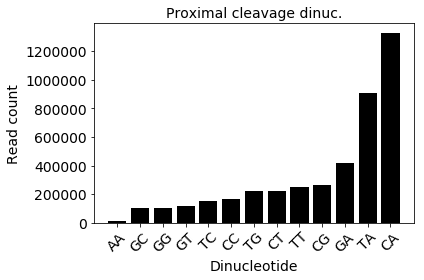

In [17]:
plot_cut_2mers(df_cleaned, proximal_cuts_cleaned)

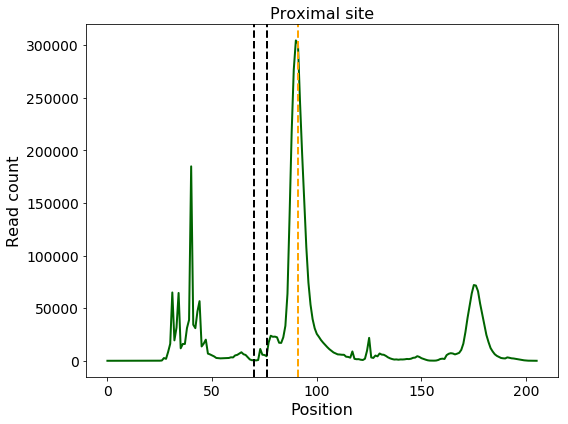

In [18]:

proximal_profile = np.ravel(proximal_cuts_cleaned.sum(axis=0))

f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(proximal_profile)), proximal_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=70, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 6, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 21, linewidth=2, c='orange', linestyle='--')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

plt.show()


In [19]:

#Filter final version on read count

total_count = np.array(df_cleaned['total_count'])
filter_index = np.nonzero(total_count >= 4)[0]

df_final = df_cleaned.iloc[filter_index].reset_index(drop=True)
proximal_cuts_final = proximal_cuts_cleaned[filter_index]

print(len(df_final))
print(proximal_cuts_final.shape[0])


815301
815301


In [20]:
#Store dataframe and cut matrices
library_version = 'final'

df_final = df_final[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_final.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_final})

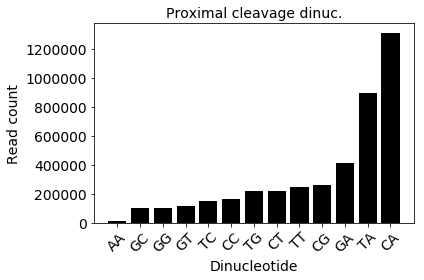

In [21]:
plot_cut_2mers(df_final, proximal_cuts_final)

Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000


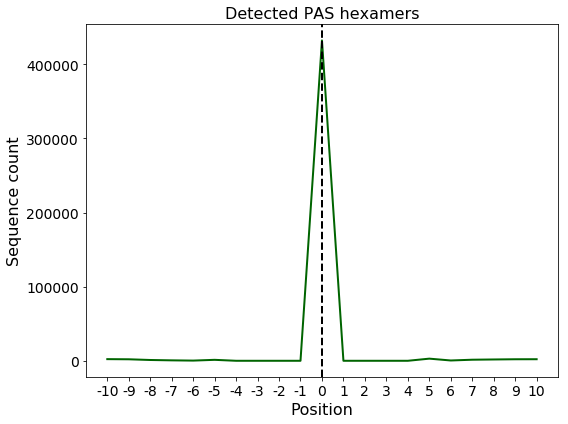

In [22]:

pas_pos_detection_histo = np.zeros(20+1)
for index, row in df_final.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))
    
    break_loop = False
    for j_width in range(0, 10 + 1) :
        for j_dir in [-1, 1] :
            j = j_width * j_dir
            j_end = j_width * j_dir + 6

            for k in range(0, len(valid_pas)) :
                if row['seq'][70 + j: 70 + j_end] in valid_pas[k] :
                    pas_pos_detection_histo[10+j] += 1

                    break_loop = True
                    break

            if break_loop :
                break
        
        if break_loop :
            break



f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(20+1), pas_pos_detection_histo, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=10, linewidth=2, c='black', linestyle='--')


plt.xticks(np.arange(20+1), np.arange(20+1)-10, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Sequence count', fontsize=16)
plt.title('Detected PAS hexamers', fontsize=16)
plt.tight_layout()

plt.show()
